In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.dirname(os.getcwd()))
#from src import cleaning
#from src import outliers_detection

### Data load

We will use information from two dataset, one containing data about the trips and the other storing zoning information about the different areas of the city of New York. THe information that we will allow to link the two is the PULocationID code and DOLocationID drom the first dataset and the LocationID from the late.

In [2]:
df = pd.read_parquet("/home/asado/Descargas/Anyone AI/final_sprint/FinalProject/yellow_tripdata_2022-05.parquet") ##change the path for your own local
df.sample(10, random_state=42) #seed of randomness for reproducibility

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
3043622,2,2022-05-27 16:45:16,2022-05-27 16:52:08,1.0,0.90,1.0,N,249,114,1,6.0,1.0,0.5,2.06,0.0,0.3,12.36,2.5,0.0
208456,1,2022-05-03 10:01:56,2022-05-03 10:19:06,1.0,0.80,1.0,N,141,141,2,6.5,2.5,0.5,0.00,0.0,0.3,9.80,2.5,0.0
942942,1,2022-05-09 16:59:46,2022-05-09 17:03:47,1.0,0.70,1.0,N,151,238,1,5.0,3.5,0.5,1.85,0.0,0.3,11.15,2.5,0.0
247636,2,2022-05-03 16:30:52,2022-05-03 16:41:19,1.0,1.72,1.0,N,87,148,1,8.5,1.0,0.5,2.56,0.0,0.3,15.36,2.5,0.0
3052006,2,2022-05-27 18:45:16,2022-05-27 18:53:46,1.0,1.54,1.0,N,42,24,1,8.0,1.0,0.5,1.96,0.0,0.3,11.76,0.0,0.0
1291561,2,2022-05-12 15:22:00,2022-05-12 15:29:22,5.0,1.03,1.0,N,107,234,1,6.5,0.0,0.5,1.00,0.0,0.3,10.80,2.5,0.0
3073378,2,2022-05-27 21:24:03,2022-05-27 21:32:10,4.0,1.19,1.0,N,161,48,1,7.0,0.5,0.5,2.16,0.0,0.3,12.96,2.5,0.0
3423926,2,2022-05-31 18:53:00,2022-05-31 19:03:35,1.0,1.78,1.0,N,163,234,1,9.0,1.0,0.5,2.66,0.0,0.3,15.96,2.5,0.0
3486168,2,2022-05-06 18:40:00,2022-05-06 18:44:00,NaN,0.83,NaN,None,87,45,0,10.0,0.0,0.5,2.00,0.0,0.3,15.30,NaN,NaN
778070,2,2022-05-07 22:12:17,2022-05-07 22:24:17,2.0,1.68,1.0,N,161,107,2,9.5,0.5,0.5,0.00,0.0,0.3,13.30,2.5,0.0


In [3]:
df2 = pd.read_csv("/home/asado/Descargas/taxi+_zone_lookup.csv")

In [4]:
#Auxiliary datasets creation
df_pickup = pd.merge(df, df2, left_on= "PULocationID", right_on= "LocationID")
df_dropoff = pd.merge(df, df2, left_on= "DOLocationID", right_on= "LocationID")


In [5]:
#Compose of the final working dataset
df["PUZone"] = df_pickup["Zone"]
df["DOZone"] = df_dropoff["Zone"]
df.sample(10, random_state=42)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PUZone,DOZone
3043622,2,2022-05-27 16:45:16,2022-05-27 16:52:08,1.0,0.90,1.0,N,249,114,1,...,1.0,0.5,2.06,0.0,0.3,12.36,2.5,0.0,Gramercy,Battery Park City
208456,1,2022-05-03 10:01:56,2022-05-03 10:19:06,1.0,0.80,1.0,N,141,141,2,...,2.5,0.5,0.00,0.0,0.3,9.80,2.5,0.0,Midtown North,East Chelsea
942942,1,2022-05-09 16:59:46,2022-05-09 17:03:47,1.0,0.70,1.0,N,151,238,1,...,3.5,0.5,1.85,0.0,0.3,11.15,2.5,0.0,Upper East Side North,Flatiron
247636,2,2022-05-03 16:30:52,2022-05-03 16:41:19,1.0,1.72,1.0,N,87,148,1,...,1.0,0.5,2.56,0.0,0.3,15.36,2.5,0.0,East Village,East Chelsea
3052006,2,2022-05-27 18:45:16,2022-05-27 18:53:46,1.0,1.54,1.0,N,42,24,1,...,1.0,0.5,1.96,0.0,0.3,11.76,0.0,0.0,Gramercy,Battery Park City
1291561,2,2022-05-12 15:22:00,2022-05-12 15:29:22,5.0,1.03,1.0,N,107,234,1,...,0.0,0.5,1.00,0.0,0.3,10.80,2.5,0.0,Flatiron,Midtown Center
3073378,2,2022-05-27 21:24:03,2022-05-27 21:32:10,4.0,1.19,1.0,N,161,48,1,...,0.5,0.5,2.16,0.0,0.3,12.96,2.5,0.0,Gramercy,Lincoln Square West
3423926,2,2022-05-31 18:53:00,2022-05-31 19:03:35,1.0,1.78,1.0,N,163,234,1,...,1.0,0.5,2.66,0.0,0.3,15.96,2.5,0.0,East Williamsburg,University Heights/Morris Heights
3486168,2,2022-05-06 18:40:00,2022-05-06 18:44:00,NaN,0.83,NaN,None,87,45,0,...,0.0,0.5,2.00,0.0,0.3,15.30,NaN,NaN,Morningside Heights,LaGuardia Airport
778070,2,2022-05-07 22:12:17,2022-05-07 22:24:17,2.0,1.68,1.0,N,161,107,2,...,0.5,0.5,0.00,0.0,0.3,13.30,2.5,0.0,Murray Hill,East Village


In [6]:
df3 = pd.read_csv("/home/asado/Descargas/taxi_zone_lookup_coordinates.csv")

In [7]:
#Auxiliary datasets creation
df_lat_pickup = pd.merge(df, df3, left_on= "PULocationID", right_on= "LocationID")
df_lat_dropoff = pd.merge(df, df3, left_on= "DOLocationID", right_on= "LocationID")

In [8]:
#Compose of the final working dataset
df["PULat"] = df_lat_pickup["latitude"]
df["PULong"] = df_lat_pickup["longitude"]
df["DOLat"] = df_lat_dropoff["latitude"]
df["DOLong"] = df_lat_dropoff["longitude"]
df.sample(10, random_state=42)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PUZone,DOZone,PULat,PULong,DOLat,DOLong
3043622,2,2022-05-27 16:45:16,2022-05-27 16:52:08,1.0,0.90,1.0,N,249,114,1,...,0.3,12.36,2.5,0.0,Gramercy,Battery Park City,40.736800,-73.984500,40.711310,-74.01590
208456,1,2022-05-03 10:01:56,2022-05-03 10:19:06,1.0,0.80,1.0,N,141,141,2,...,0.3,9.80,2.5,0.0,Midtown North,East Chelsea,40.754932,-73.984016,40.742352,-74.00621
942942,1,2022-05-09 16:59:46,2022-05-09 17:03:47,1.0,0.70,1.0,N,151,238,1,...,0.3,11.15,2.5,0.0,Upper East Side North,Flatiron,40.764100,-73.956000,40.740100,-73.99030
247636,2,2022-05-03 16:30:52,2022-05-03 16:41:19,1.0,1.72,1.0,N,87,148,1,...,0.3,15.36,2.5,0.0,East Village,East Chelsea,40.726500,-73.981500,40.742352,-74.00621
3052006,2,2022-05-27 18:45:16,2022-05-27 18:53:46,1.0,1.54,1.0,N,42,24,1,...,0.3,11.76,0.0,0.0,Gramercy,Battery Park City,40.736800,-73.984500,40.711310,-74.01590
1291561,2,2022-05-12 15:22:00,2022-05-12 15:29:22,5.0,1.03,1.0,N,107,234,1,...,0.3,10.80,2.5,0.0,Flatiron,Midtown Center,40.740100,-73.990300,40.758800,-73.97291
3073378,2,2022-05-27 21:24:03,2022-05-27 21:32:10,4.0,1.19,1.0,N,161,48,1,...,0.3,12.96,2.5,0.0,Gramercy,Lincoln Square West,40.736800,-73.984500,40.776780,-73.98296
3423926,2,2022-05-31 18:53:00,2022-05-31 19:03:35,1.0,1.78,1.0,N,163,234,1,...,0.3,15.96,2.5,0.0,East Williamsburg,University Heights/Morris Heights,40.708000,-73.939900,40.851830,-73.91626
3486168,2,2022-05-06 18:40:00,2022-05-06 18:44:00,NaN,0.83,NaN,None,87,45,0,...,0.3,15.30,NaN,NaN,Morningside Heights,LaGuardia Airport,40.810000,-73.962500,40.770130,-73.86703
778070,2,2022-05-07 22:12:17,2022-05-07 22:24:17,2.0,1.68,1.0,N,161,107,2,...,0.3,13.30,2.5,0.0,Murray Hill,East Village,40.747900,-73.975700,40.726500,-73.98150


### Descriptive analysis

In [9]:
print(f"This dataset is composed of {df.shape[0]} rows and {df.shape[1]} columns")

This dataset is composed of 3588295 rows and 25 columns


Since the dataset its extensive and modeling it's gonna consume a lot of hardware, we will work with a subsample.

In [9]:
df_subset = df.sample(100000, random_state=42) #seed of randomness for reproducibility

In [24]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 3043622 to 1089672
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               10000 non-null  int64         
 1   tpep_pickup_datetime   10000 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  10000 non-null  datetime64[ns]
 3   passenger_count        9633 non-null   float64       
 4   trip_distance          10000 non-null  float64       
 5   RatecodeID             9633 non-null   float64       
 6   store_and_fwd_flag     9633 non-null   object        
 7   PULocationID           10000 non-null  int64         
 8   DOLocationID           10000 non-null  int64         
 9   payment_type           10000 non-null  int64         
 10  fare_amount            10000 non-null  float64       
 11  extra                  10000 non-null  float64       
 12  mta_tax                10000 non-null  float64       
 13

We have a combination of datetime, integer and float type of variables with a few object type. We will have to deal somehow with the latter.

### Check for unique values and na's

In [10]:
df_subset.isna().sum()/df_subset.shape[0]*100

VendorID                 0.000
tpep_pickup_datetime     0.000
tpep_dropoff_datetime    0.000
passenger_count          3.594
trip_distance            0.000
RatecodeID               3.594
store_and_fwd_flag       3.594
PULocationID             0.000
DOLocationID             0.000
payment_type             0.000
fare_amount              0.000
extra                    0.000
mta_tax                  0.000
tip_amount               0.000
tolls_amount             0.000
improvement_surcharge    0.000
total_amount             0.000
congestion_surcharge     3.594
airport_fee              3.594
PUZone                   0.236
DOZone                   0.356
PULat                    1.412
PULong                   0.236
DOLat                    1.069
DOLong                   0.356
dtype: float64

Very few null values, so they can be taken out of the dataset without losing much information.

In [11]:
df.nunique()/df.shape[0]*100

VendorID                  0.000111
tpep_pickup_datetime     48.900968
tpep_dropoff_datetime    48.849635
passenger_count           0.000279
trip_distance             0.132960
RatecodeID                0.000195
store_and_fwd_flag        0.000056
PULocationID              0.007218
DOLocationID              0.007274
payment_type              0.000139
fare_amount               0.226821
extra                     0.001700
mta_tax                   0.000362
tip_amount                0.105315
tolls_amount              0.021431
improvement_surcharge     0.000084
total_amount              0.400720
congestion_surcharge      0.000195
airport_fee               0.000084
PUZone                    0.007162
DOZone                    0.007218
PULat                     0.006856
PULong                    0.006828
DOLat                     0.006911
DOLong                    0.006883
dtype: float64

We can say that we dont have a lot of variability in the dataset, except for two variables that will be transformed in the next step.

### Creation of a "duration" variable

One of the aims of the projects it's to predict duration of the trips, so we will create the duration variable, containing the information pertaining how much (in minutes) a trip lasted, calculating a diference between trip drop-off and pick up, as it follows:

In [12]:
df_subset["duration"] = df_subset["tpep_dropoff_datetime"] - df_subset["tpep_pickup_datetime"]
df_subset["duration"] = df_subset["duration"].dt.total_seconds() / 60

In [13]:
round(df_subset.describe(),2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PULat,PULong,DOLat,DOLong,duration
count,100000.00,100000,100000,96406.00,100000.00,96406.00,100000.00,100000.00,100000.00,100000.00,...,100000.00,100000.00,100000.00,96406.00,96406.00,98588.00,99764.00,98931.00,99644.00,100000.00
mean,1.71,2022-05-16 06:53:58.613990144,2022-05-16 07:12:11.823000320,1.39,4.83,1.40,164.33,162.59,1.18,15.16,...,0.59,0.30,22.10,2.28,0.10,40.75,-74.46,40.76,-74.27,18.22
min,1.00,2008-12-31 23:06:01,2009-01-01 22:30:46,0.00,0.00,1.00,1.00,1.00,0.00,-300.00,...,-50.75,-0.30,-245.74,-2.50,-1.25,40.51,-116.66,40.51,-116.66,-0.93
25%,1.00,2022-05-08 17:40:03,2022-05-08 17:59:28.249999872,1.00,1.15,1.00,132.00,113.00,1.00,7.00,...,0.00,0.30,12.35,2.50,0.00,40.74,-73.99,40.74,-73.99,7.63
50%,2.00,2022-05-16 09:30:06,2022-05-16 09:47:41,1.00,1.95,1.00,162.00,162.00,1.00,10.50,...,0.00,0.30,16.30,2.50,0.00,40.75,-73.98,40.75,-73.98,12.65
75%,2.00,2022-05-23 17:28:43.500000,2022-05-23 17:48:56.249999872,1.00,3.71,1.00,234.00,234.00,1.00,17.00,...,0.00,0.30,23.75,2.50,0.00,40.77,-73.96,40.77,-73.96,20.52
max,6.00,2022-05-31 23:59:49,2022-06-01 18:19:50,6.00,60419.14,99.00,265.00,265.00,4.00,400.00,...,86.00,0.30,400.30,2.50,1.25,42.45,-71.20,42.45,-71.20,1640.52
std,0.49,NaN,NaN,0.95,264.03,5.52,65.57,70.23,0.50,14.33,...,2.11,0.05,18.05,0.75,0.34,0.05,4.61,0.06,3.60,51.56


### EDA graphical phase

- Plots for numerical variables

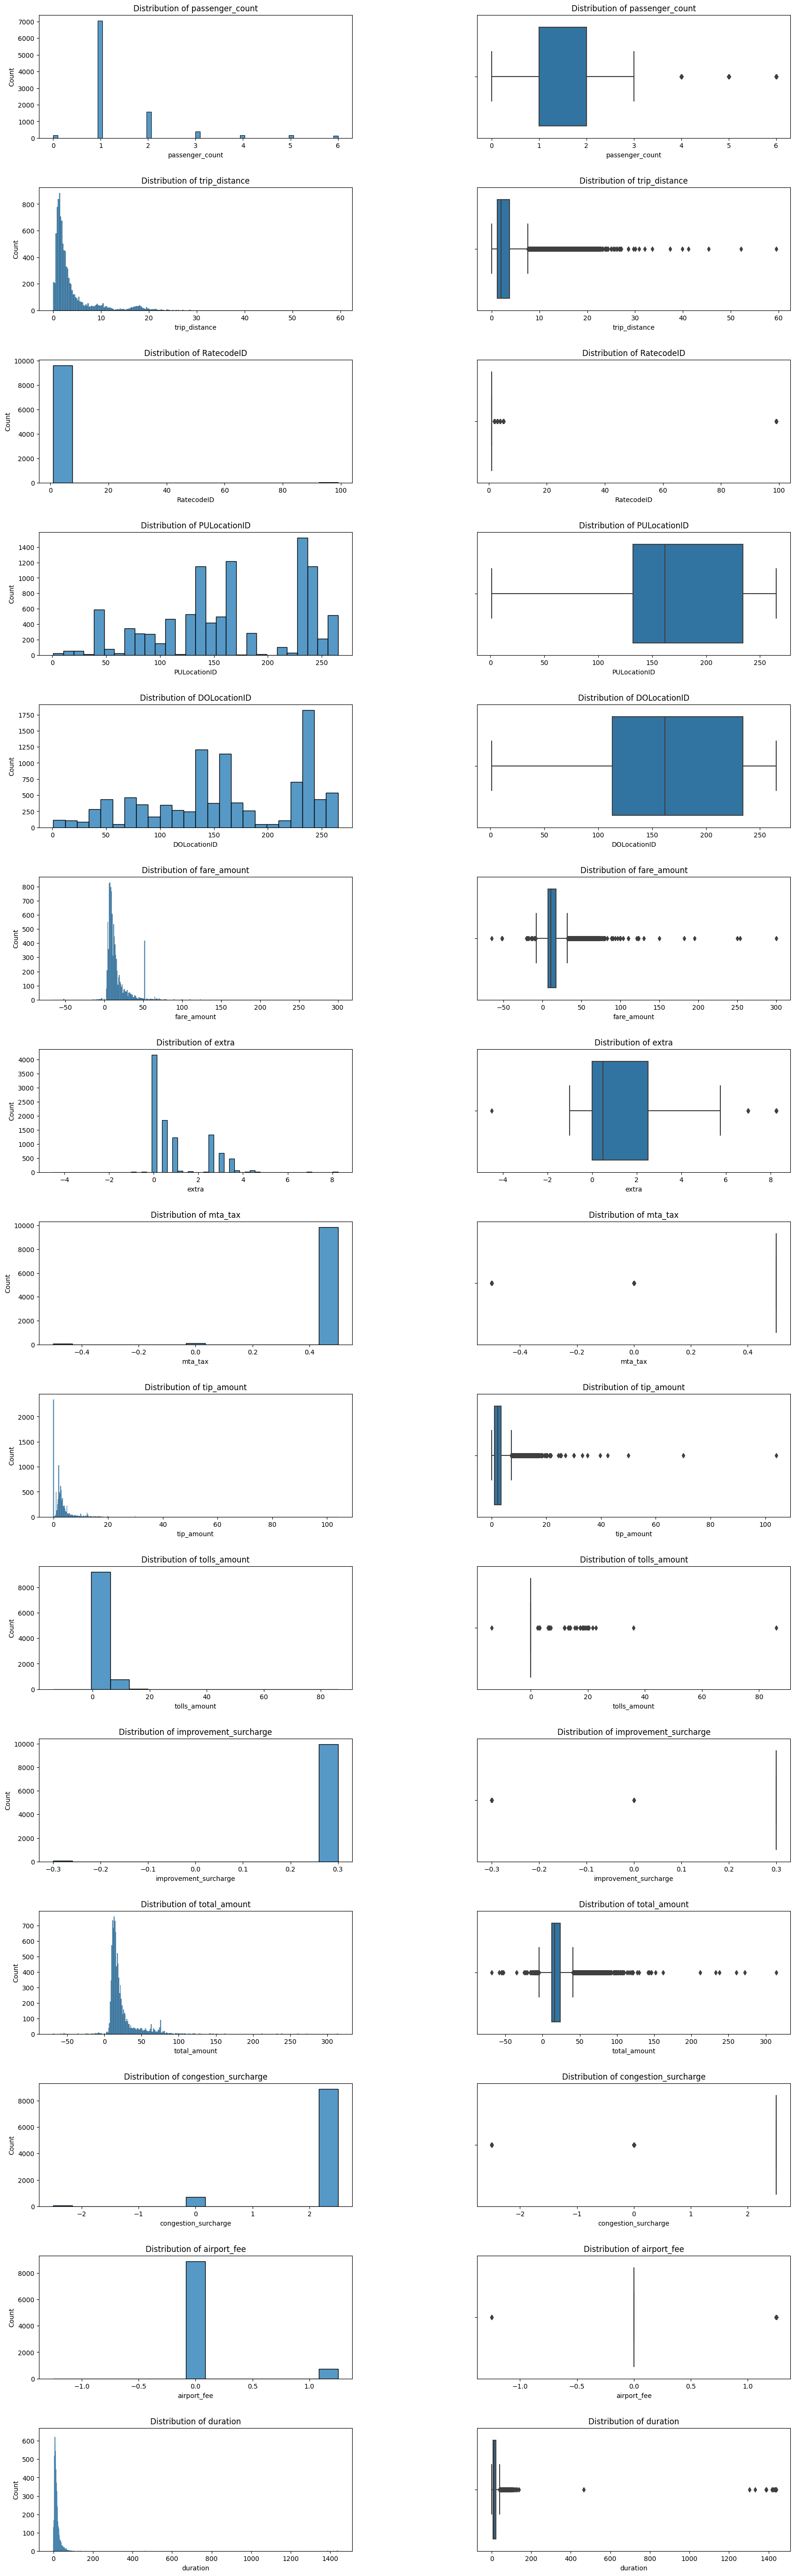

In [142]:
#string_columns = df_subset.select_dtypes(include='object')
columns = df_subset.drop(['store_and_fwd_flag', 'PUZone', 'DOZone', 'PUZone', 'DOZone', 'PULat',
       'PULong', 'DOLat', 'DOLong'], axis=1).columns
fig, axes = plt.subplots(nrows=len(columns), ncols=2, figsize=(20,60))

for index, col in enumerate(columns):
  axes[index][0].set_title(f"Distribution of {col}")
  sns.histplot(x=df_subset[col], ax=axes[index][0])
  axes[index][1].set_title(f"Distribution of {col}")
  sns.boxplot(x=df_subset[col], ax=axes[index][1])

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

Many of our numerical variables have outliers, which are defined in this notebook as the observation that lies an abnormal distance from a Q1/Q3 +- 1.5 IQR. We will deal with this values in the next section.

Knowing that the dataset contains variables that are not informative, we will drop the variables "Vendor ID" (just codifies the company on wich the cellphone works), "store_and_fwd_flag" (not relevant information) and "payment_type" (just code the customers prefered payment type and there is an overrepresentaion of cash).

In [14]:
df_subset = df_subset.drop(["VendorID", "payment_type"], axis=1)

- Now, plots for object type of variables

Since both Pick up and Drop off zone have a lot of unique values [1], in order to make an accesible and understandable plot, we are going to group each one of these two object type variables in ad-hoc dataframes and plot the 10 most frequent as it follows.

In [284]:
#[1]
df_subset["PUZone"].nunique(),  df_subset["DOZone"].nunique()

(140, 204)

In [268]:
#Auxiliary grouping dataframes
grouping_PU_df = pd.DataFrame(df_subset["PUZone"].value_counts().sort_values(ascending = False).head(10))
grouping_DO_df = pd.DataFrame(df_subset["DOZone"].value_counts().sort_values(ascending = False).head(10))

In [269]:
#Index reset
grouping_PU_df.reset_index(inplace=True)
grouping_PU_df = grouping_PU_df.rename(columns = {'index':'new column name'})
grouping_DO_df.reset_index(inplace=True)
grouping_DO_df = grouping_DO_df.rename(columns = {'index':'new column name'})

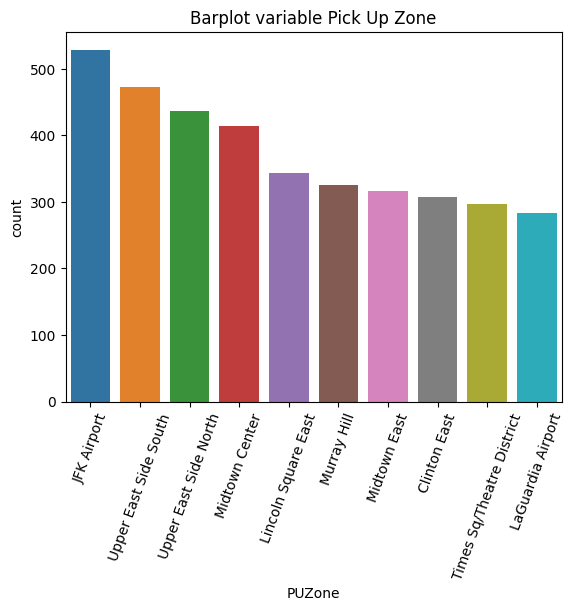

In [270]:
#Plot PUZone
fig = plt.figure()
ax = plt.axes()
ax = sns.barplot(x= grouping_PU_df["PUZone"], y = grouping_PU_df["count"], data=grouping_PU_df)
plt.xticks(rotation=70)
plt.title("Barplot variable Pick Up Zone")
plt.show()

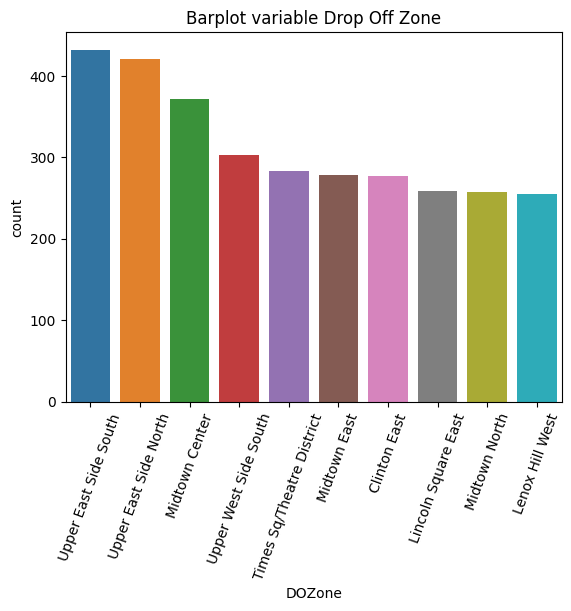

In [272]:
#Plot DOZone
fig = plt.figure()
ax = plt.axes()
ax = sns.barplot(x= grouping_DO_df["DOZone"], y = grouping_DO_df["count"], data=grouping_DO_df)
plt.xticks(rotation=70)
plt.title("Barplot variable Drop Off Zone")
plt.show()

In [15]:
df_subset = df_subset.drop(["store_and_fwd_flag"], axis=1)

### Outliers detection

In [23]:
def outliers_detection (variable):
  fig, axes = plt.subplots(nrows=1, ncols=2)
  fig.suptitle(variable)
  axes[0].hist(filtered_df[variable])
  axes[1].boxplot(x=variable, data=df)
  plt.show()
  percentile_25 = np.percentile(filtered_df[variable], 25)
  percentile_50 = np.percentile(filtered_df[variable], 50)
  percentile_75 = np.percentile(filtered_df[variable], 75)
  print(f"mín = {filtered_df[variable].min()}")
  print(f"Percentile 0.25 = {percentile_25}")
  print(f"Percentile 0.50 = {percentile_25}")
  print(f"Percentile 0.75 = {percentile_75}")
  print(f"max = {filtered_df[variable].max()}")

In [25]:
def clean_outliers (variable):
  iqr = np.percentile(filtered_df[variable], 75)- np.percentile(df_subset[variable], 25)
  max = np.percentile(filtered_df[variable], 75) + 1.5 *iqr
  min = np.percentile(filtered_df[variable], 25)- 1.5*iqr
  filtered = filtered_df[(filtered_df[variable] <= max) & (filtered_df[variable] >= min)]
  return filtered

- Passenger count (erase the observation with value 0)
- Trip distance
- Rate code id (there is one observation with code of 90)
- Fare amount (erase negatives and > 200)
- Extra (erase negatives)
- Mta. Tax (erase negatives)
- Tolls (erase negatives)
- Improvement (erase negatives)
- Airport fee
- Congestion (erase negatives)

In [125]:
filtered_df = df_subset.dropna()

In [126]:
filtered_df.shape

(94161, 23)

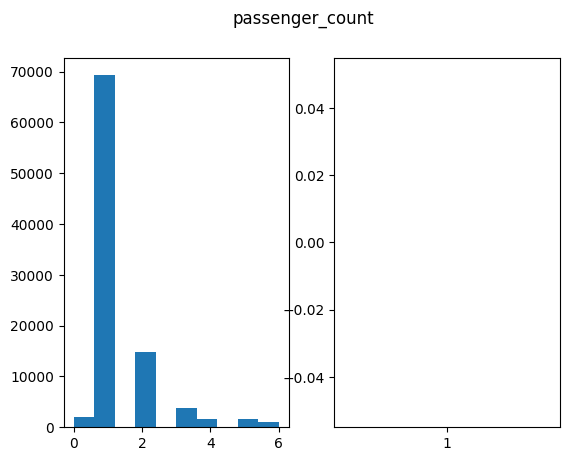

mín = 0.0
Percentile 0.25 = 1.0
Percentile 0.50 = 1.0
Percentile 0.75 = 1.0
max = 6.0


In [24]:
outliers_detection('passenger_count')

In [127]:
filtered_df = filtered_df[(filtered_df["passenger_count"] >0) & (filtered_df["passenger_count"] <= 4 )]

In [102]:
filtered_df.shape

(89426, 23)

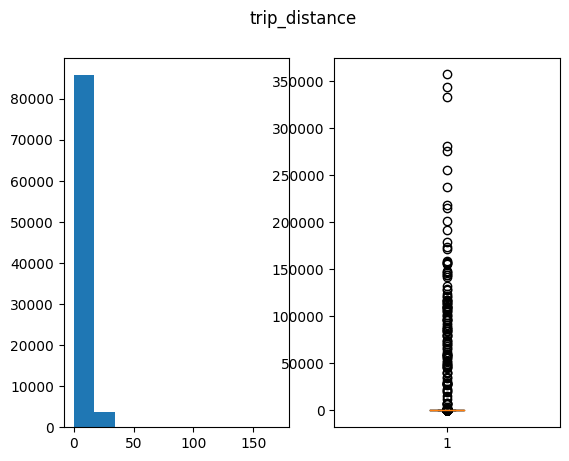

mín = 0.0
Percentile 0.25 = 1.13
Percentile 0.50 = 1.13
Percentile 0.75 = 3.62
max = 171.4


In [28]:
outliers_detection('trip_distance')

In [128]:
filtered_df = filtered_df[filtered_df["trip_distance"] > 0]

In [104]:
filtered_df.shape

(88235, 23)

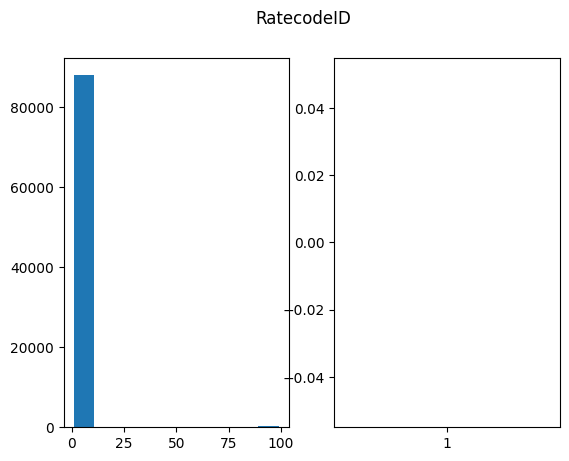

mín = 1.0
Percentile 0.25 = 1.0
Percentile 0.50 = 1.0
Percentile 0.75 = 1.0
max = 99.0


In [30]:
outliers_detection('RatecodeID')

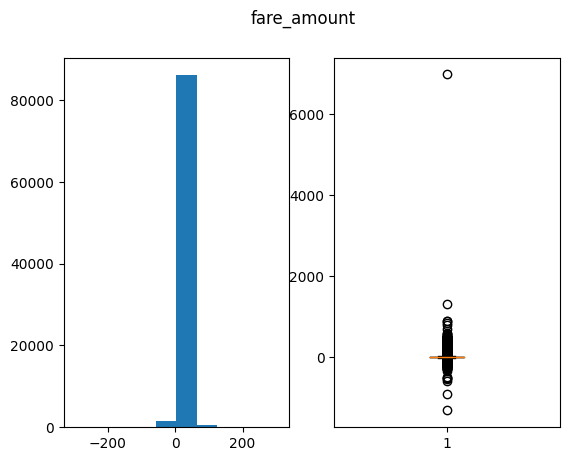

mín = -300.0
Percentile 0.25 = 7.0
Percentile 0.50 = 7.0
Percentile 0.75 = 16.5
max = 307.5


In [31]:
outliers_detection('fare_amount')

In [129]:
filtered_df = filtered_df[(filtered_df["fare_amount"] < 3000) & (filtered_df["fare_amount"] > 0)]

In [113]:
filtered_df.shape

(87754, 23)

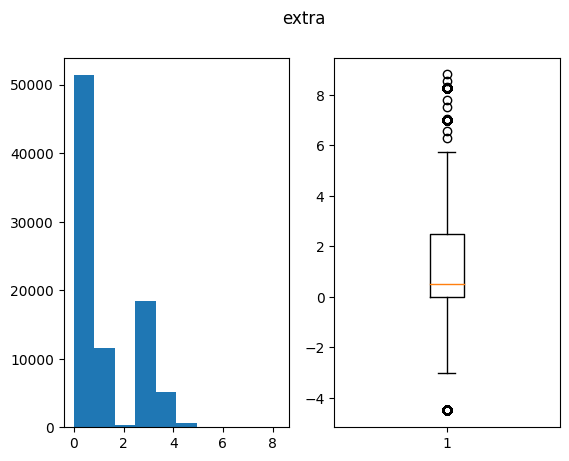

mín = 0.0
Percentile 0.25 = 0.0
Percentile 0.50 = 0.0
Percentile 0.75 = 2.5
max = 8.25


In [33]:
outliers_detection('extra')

In [114]:
#filtered_df = filtered_df[filtered_df["extra"] > 0]

In [120]:
filtered_df.shape

(87754, 23)

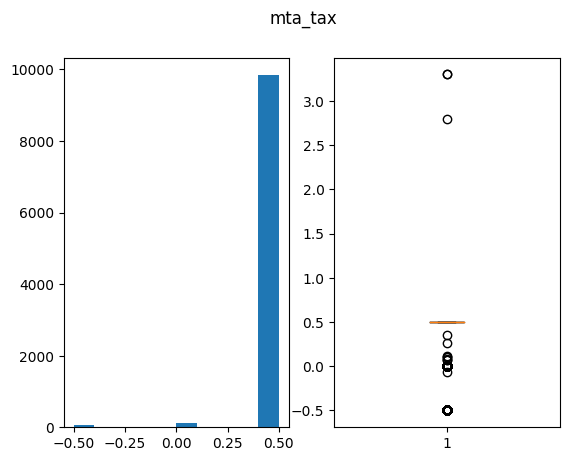

mín = -0.5
Percentile 0.25 = 0.5
Percentile 0.50 = 0.5
Percentile 0.75 = 0.5
max = 0.5


In [28]:
outliers_detection('mta_tax')

In [130]:
filtered_df = filtered_df[(filtered_df["mta_tax"] < 2.5) & (filtered_df["mta_tax"] > 0.25)]

In [131]:
filtered_df.shape

(87084, 23)

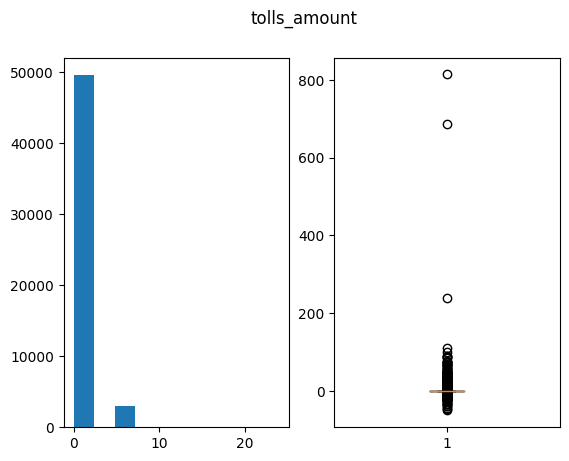

mín = 0.0
Percentile 0.25 = 0.0
Percentile 0.50 = 0.0
Percentile 0.75 = 0.0
max = 24.0


In [36]:
outliers_detection('tolls_amount')

In [123]:
#filtered_df = filtered_df[filtered_df["tolls_amount"] > 0]

In [124]:
filtered_df.shape

(6867, 23)

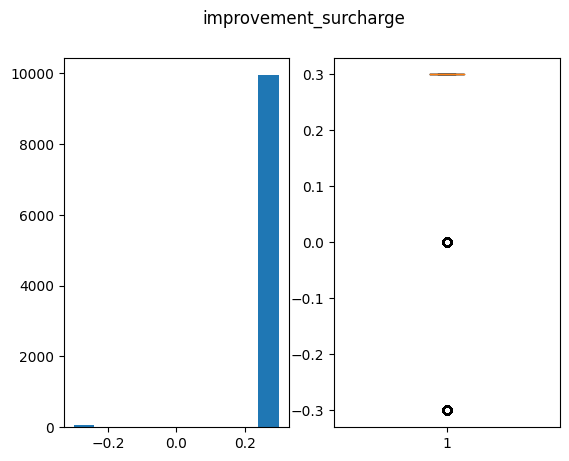

mín = -0.3
Percentile 0.25 = 0.3
Percentile 0.50 = 0.3
Percentile 0.75 = 0.3
max = 0.3


In [34]:
outliers_detection('improvement_surcharge')

In [132]:
filtered_df = filtered_df[filtered_df["improvement_surcharge"] > 0]

In [133]:
filtered_df.shape

(87083, 23)

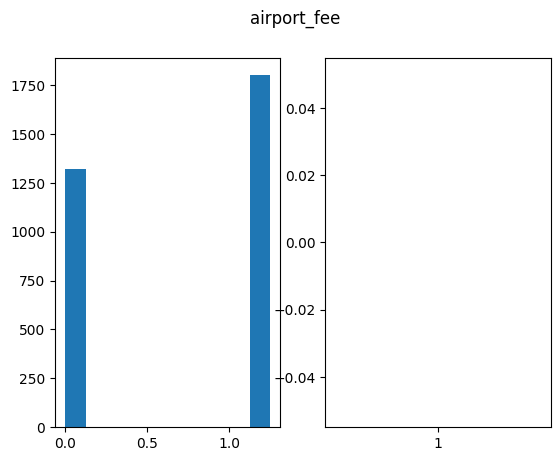

mín = 0.0
Percentile 0.25 = 0.0
Percentile 0.50 = 0.0
Percentile 0.75 = 1.25
max = 1.25


In [39]:
outliers_detection('airport_fee')

In [61]:
#filtered_df = filtered_df[(filtered_df["airport_fee"] < 1) & (filtered_df["fare_amount"] > 0)]

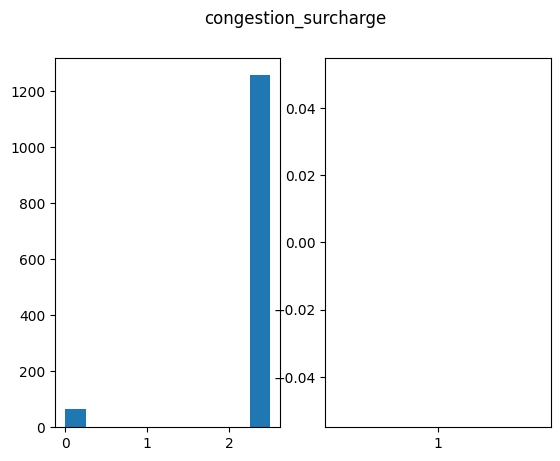

mín = 0.0
Percentile 0.25 = 2.5
Percentile 0.50 = 2.5
Percentile 0.75 = 2.5
max = 2.5


In [41]:
outliers_detection('congestion_surcharge')

In [62]:
#filtered_df = filtered_df[filtered_df["congestion_surcharge"] > 0]

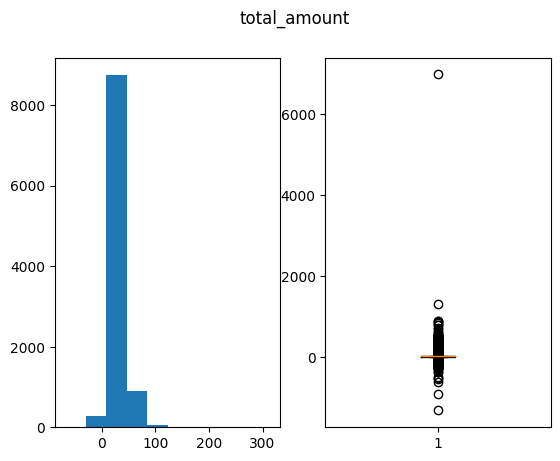

mín = -68.55
Percentile 0.25 = 12.36
Percentile 0.50 = 12.36
Percentile 0.75 = 23.76
max = 314.05


In [40]:
outliers_detection('total_amount')

In [134]:
filtered_df = filtered_df[ filtered_df["total_amount"] > 0]

In [135]:
filtered_df.shape

(87083, 23)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U1'), dtype('<U1')) -> None

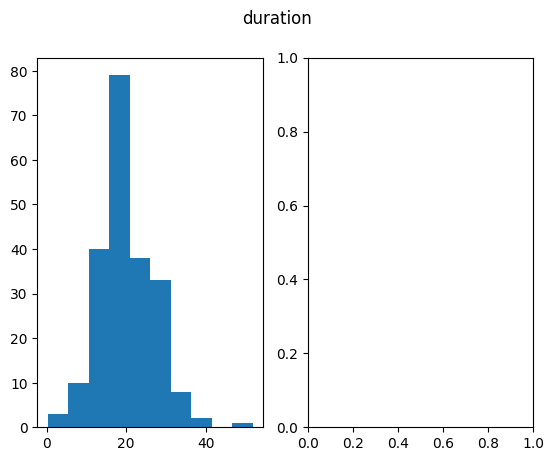

In [43]:
outliers_detection("duration")

In [136]:
filtered_df = filtered_df[filtered_df["duration"] > 0]

In [137]:
filtered_df.shape

(87079, 23)

In [19]:
filtered_df = clean_outliers('trip_distance')
filtered_df = clean_outliers('RatecodeID')
filtered_df = clean_outliers('fare_amount')
filtered_df = clean_outliers('extra')
filtered_df = clean_outliers('mta_tax')
filtered_df = clean_outliers('tolls_amount')
filtered_df = clean_outliers('improvement_surcharge')
filtered_df = clean_outliers('improvement_surcharge')
filtered_df = clean_outliers('congestion_surcharge')
filtered_df = clean_outliers('total_amount')

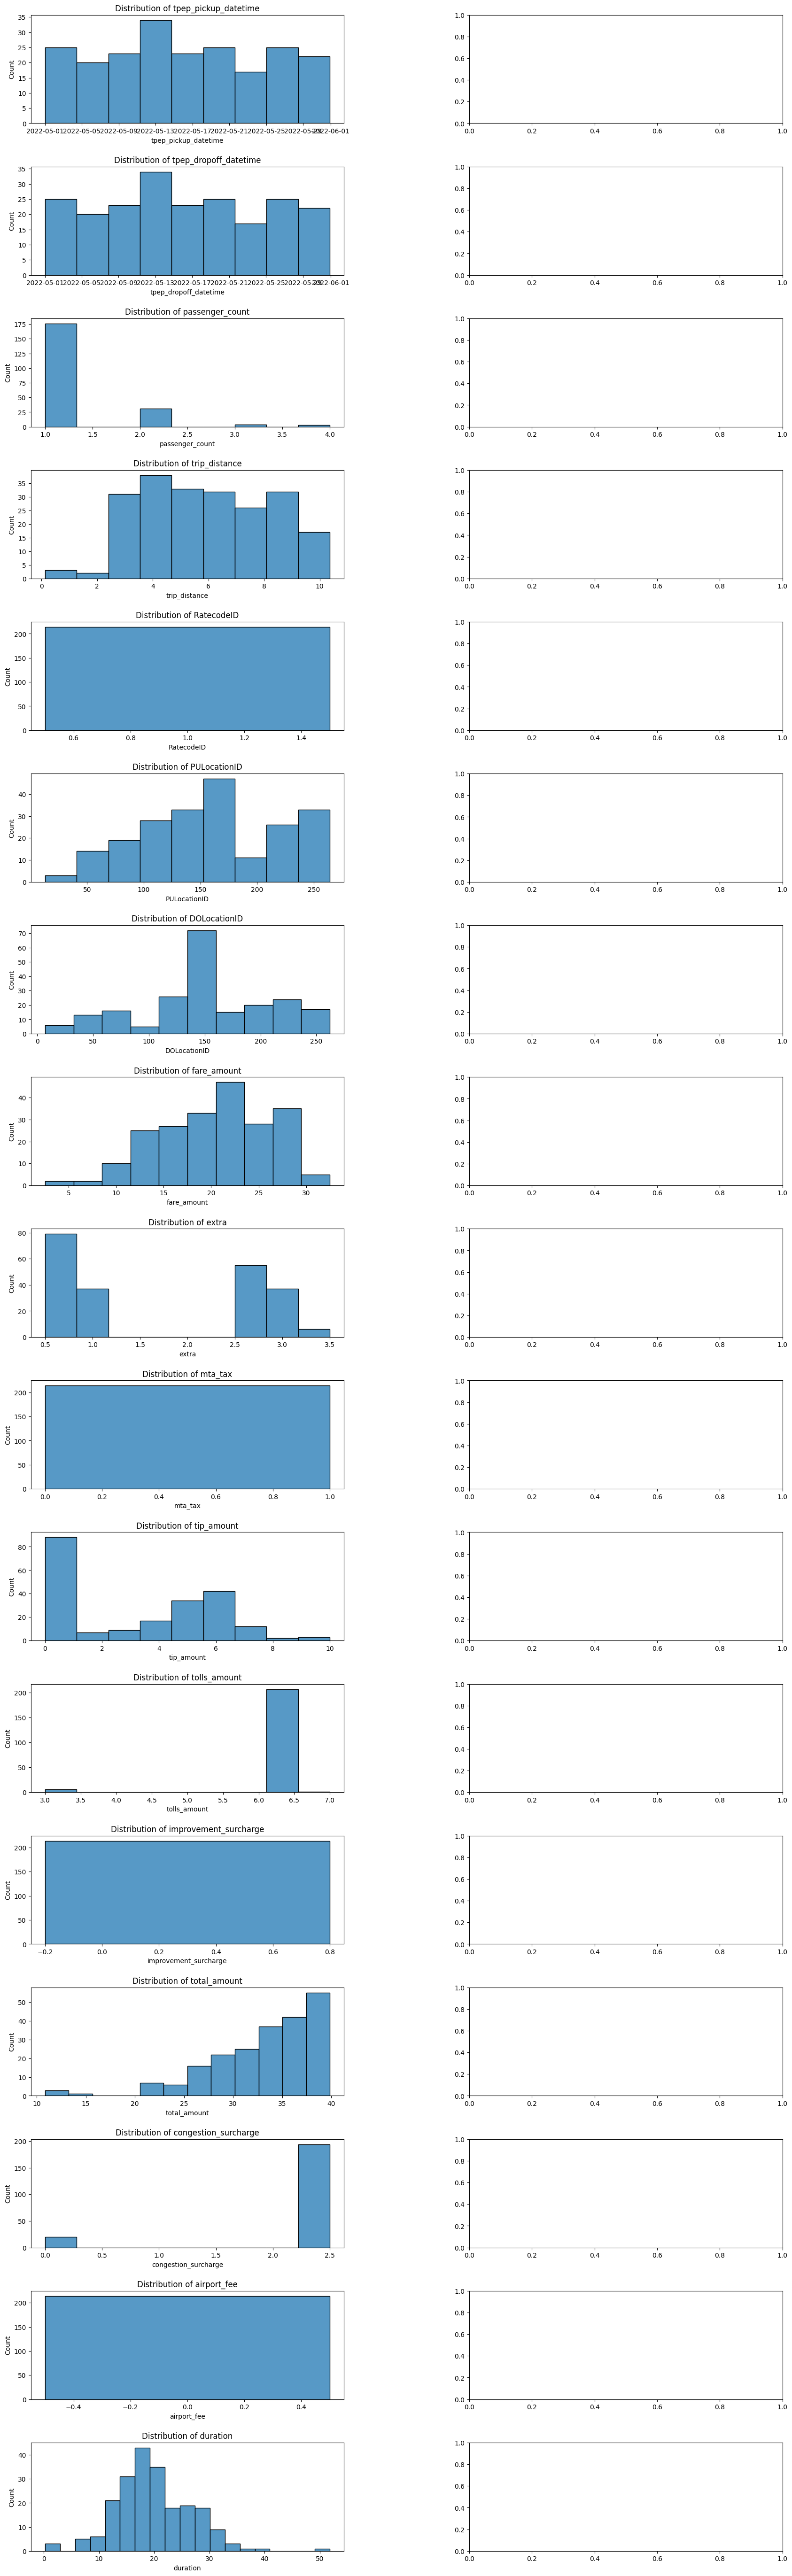

In [46]:
columns = filtered_df.drop(['PUZone', 'DOZone','PULat',
       'PULong', 'DOLat', 'DOLong'], axis=1).columns
fig, axes = plt.subplots(nrows=len(columns), ncols=2, figsize=(20,60))

for index, col in enumerate(columns):
  axes[index][0].set_title(f"Distribution of {col}")
  sns.histplot(x=filtered_df[col], ax=axes[index][0])
  #axes[index][1].set_title(f"Distribution of {col}")
  #sns.boxplot(x=filtered_df[col], ax=axes[index][1])

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

#### Feature engineering: most congested zones and hours

In [20]:
df_congestion = filtered_df[filtered_df["congestion_surcharge"] > 0]
df_congestion["DOZone"].value_counts().head(10)

DOZone
Upper East Side North           366
Upper East Side South           347
Midtown Center                  311
Upper West Side South           259
Clinton East                    239
Times Sq/Theatre District       226
Midtown East                    225
Lincoln Square East             225
Penn Station/Madison Sq West    216
Lenox Hill West                 216
Name: count, dtype: int64

In [21]:
peak_hour = df_congestion["tpep_dropoff_datetime"].dt.hour.value_counts().head(20)
peak_hour

tpep_dropoff_datetime
18    580
19    567
17    519
15    510
16    497
21    463
20    458
13    453
14    453
12    435
11    414
22    402
10    380
23    355
9     330
8     256
0     228
7     211
1     198
2     113
Name: count, dtype: int64

In [ ]:
filtered_df['is_peak_hour'] = np.where(filtered_df['tpep_dropoff_datetime'].dt.hour == peak_hour, 1, 0)

In [138]:
filtered_df = filtered_df.drop(["tpep_pickup_datetime", "tpep_dropoff_datetime"], axis=1)

### Correlation map

In [139]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87079 entries, 3043622 to 701521
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   passenger_count        87079 non-null  float64
 1   trip_distance          87079 non-null  float64
 2   RatecodeID             87079 non-null  float64
 3   PULocationID           87079 non-null  int64  
 4   DOLocationID           87079 non-null  int64  
 5   fare_amount            87079 non-null  float64
 6   extra                  87079 non-null  float64
 7   mta_tax                87079 non-null  float64
 8   tip_amount             87079 non-null  float64
 9   tolls_amount           87079 non-null  float64
 10  improvement_surcharge  87079 non-null  float64
 11  total_amount           87079 non-null  float64
 12  congestion_surcharge   87079 non-null  float64
 13  airport_fee            87079 non-null  float64
 14  PUZone                 87079 non-null  object 
 15  

In [91]:
df_numerics = filtered_df.drop(['PUZone', 'DOZone','PULat',
       'PULong', 'DOLat', 'DOLong'], axis= 1)

<Axes: >

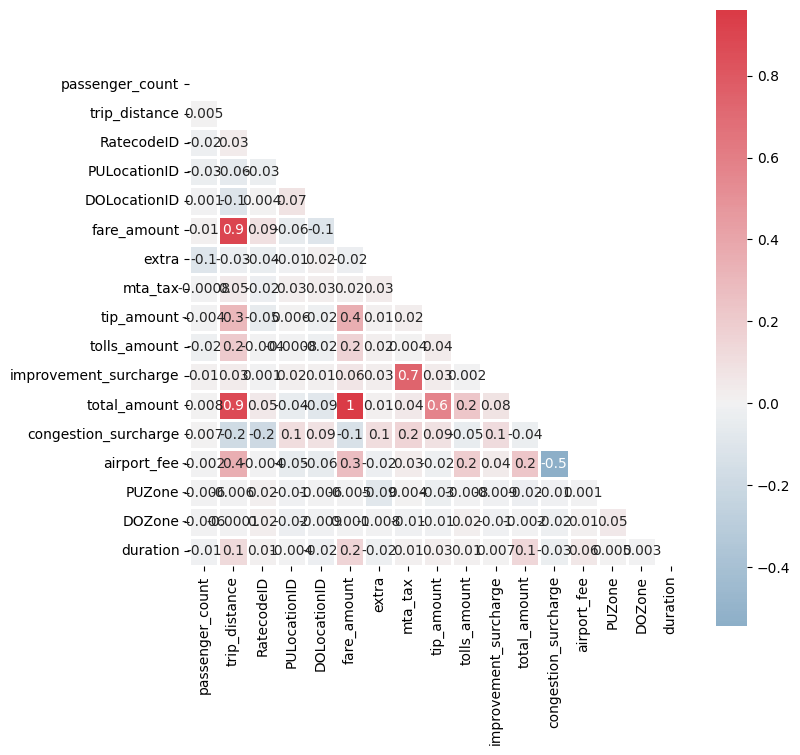

In [92]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_numerics.corr(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_numerics.corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.8, annot=True, fmt='.1g')

### Density heatmap

- Pick up passengers

In [158]:
import plotly.express as px
fig = px.density_mapbox(filtered_df, lat='PULat', lon='PULong', z='fare_amount', radius=5,
                        center=dict(lat=40.730610, lon=-73.935242), zoom=9,
                        mapbox_style="stamen-terrain")
fig.show()

- Drop passengers

In [157]:
import plotly.express as px
fig = px.density_mapbox(filtered_df, lat='DOLat', lon='DOLong', z='fare_amount', radius=5,
                        center=dict(lat=40.730610, lon=-73.935242), zoom=9,
                        mapbox_style="stamen-terrain")
fig.show()

In [159]:
import plotly.express as px
fig = px.density_mapbox(filtered_df, lat='PULat', lon='PULong', z='duration', radius=5,
                        center=dict(lat=40.730610, lon=-73.935242), zoom=9,
                        mapbox_style="stamen-terrain")
fig.show()

In [160]:
import plotly.express as px
fig = px.density_mapbox(filtered_df, lat='DOLat', lon='DOLong', z='duration', radius=5,
                        center=dict(lat=40.730610, lon=-73.935242), zoom=9,
                        mapbox_style="stamen-terrain")
fig.show()

### Na's drop

In [88]:
filtered_df = filtered_df.dropna()

### Zone encoder

In [140]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder() 
filtered_df["PUZone"] = encoder.fit_transform(filtered_df[["PUZone"]])

/home/asado/.local/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [141]:
encoder = LabelEncoder() 
filtered_df["DOZone"] = encoder.fit_transform(filtered_df[["DOZone"]])

/home/asado/.local/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Train/test split

In [93]:
df_numerics = filtered_df

In [94]:
df_numerics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8307 entries, 3043622 to 1089672
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   passenger_count        8307 non-null   float64
 1   trip_distance          8307 non-null   float64
 2   RatecodeID             8307 non-null   float64
 3   PULocationID           8307 non-null   int64  
 4   DOLocationID           8307 non-null   int64  
 5   fare_amount            8307 non-null   float64
 6   extra                  8307 non-null   float64
 7   mta_tax                8307 non-null   float64
 8   tip_amount             8307 non-null   float64
 9   tolls_amount           8307 non-null   float64
 10  improvement_surcharge  8307 non-null   float64
 11  total_amount           8307 non-null   float64
 12  congestion_surcharge   8307 non-null   float64
 13  airport_fee            8307 non-null   float64
 14  PUZone                 8307 non-null   int64  
 15  

In [95]:
X = df_numerics.drop("fare_amount", axis=1)
y = df_numerics["fare_amount"]

In [96]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6645, 20)
(1662, 20)
(6645,)
(1662,)


### First model: linear regression

In [98]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

R square for linear explicability

In [99]:
reg.score(X_train, y_train), reg.score(X_test, y_test)

(0.9954209133713215, 0.9954524813289446)

In [100]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

ValueError: All arrays must be of the same length

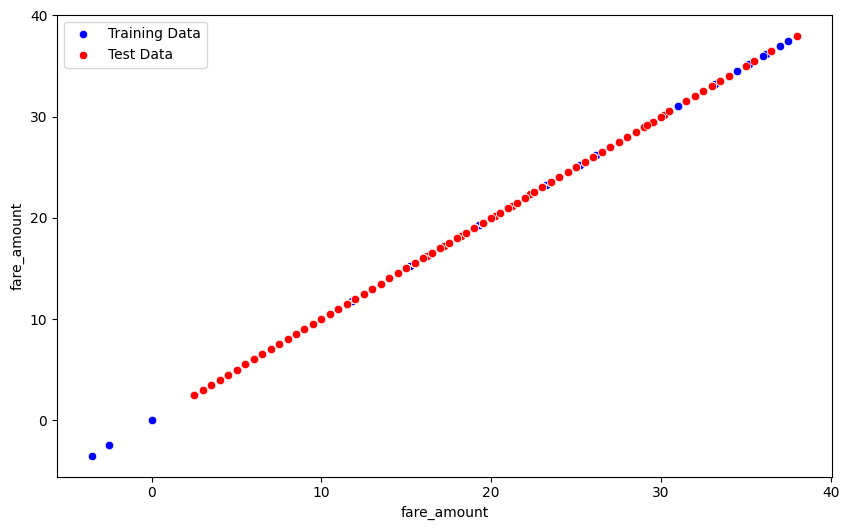

In [135]:
# Reshaping the data to be 1-dimensional
X_train_1d = df_numerics["fare_amount"]
X_test_1d = df_numerics["fare_amount"]

# Plotting the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_1d, y=y_train, color='blue', label='Training Data')
sns.scatterplot(x=X_test_1d, y=y_test, color='red', label='Test Data')

# Plotting the regression line
sns.lineplot(x=np.concatenate([X_train_1d, X_test_1d]), y=np.concatenate([y_train_pred, y_test_pred]), color='green', label='Regression Line')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Regression Line and Scatterplot')
plt.legend()
plt.show()

MSE for measuring performance

In [101]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, reg.predict(X_train)), mean_squared_error(y_test, reg.predict(X_test))

(0.1514744774494034, 0.15485372996032717)

- LInear regression for duration variable

In [126]:
X = df_numerics[["trip_distance","fare_amount", "congestion_surcharge", 
"airport_fee", "PULat", "PULong", "DOLat", "DOLong"]]
y = df_numerics["duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train), reg.score(X_test, y_test)

(0.026580792939998266, 0.016435817301906464)

In [119]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
mean_squared_error(y_train, reg.predict(X_train)), mean_squared_error(y_test, reg.predict(X_test))

(2630.855008905921, 2433.824671446551)

- Hora pico o no como categoria
- Chequear si hay mas de un dropout zone por viaje (viajes compartidos). Googlear 

### Second model: XGRegression

- XGRegression for fare amount variable

In [121]:
X = df_numerics.drop("fare_amount", axis=1)
y = df_numerics["fare_amount"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
from xgboost import XGBRegressor
xgreg = XGBRegressor()
xgreg.fit(X_train, y_train)
xgreg.score(X_train, y_train), xgreg.score(X_test, y_test)

(0.9996454499612865, 0.9875298514982349)

In [123]:
mean_squared_error(y_train, xgreg.predict(X_train)), mean_squared_error(y_test, xgreg.predict(X_test))

(0.011728383015830077, 0.424637950570381)

- XGRegression for duration variable

In [154]:
X = df_numerics.drop("duration", axis=1)
y = df_numerics["duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [155]:
xgreg = XGBRegressor()
xgreg.fit(X_train, y_train)
xgreg.score(X_train, y_train), xgreg.score(X_test, y_test)

(0.9985534390052835, -1.6343580127067314)

In [156]:
mean_squared_error(y_train, xgreg.predict(X_train)), mean_squared_error(y_test, xgreg.predict(X_test))

(3.909612848232171, 6518.705782026824)

. Analizar si eliminar congestion surcharge

si es relevante para duration

----------------------------------------------------------------------------------------------------------------------------------------------------------

#### Standarization and SVM for regression

In [143]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(filtered_df, test_size=0.2, random_state=42, shuffle=True)

In [144]:
train_df.shape, test_df.shape

((69663, 21), (17416, 21))

In [145]:
X_train = train_df.drop("duration", axis=1)
X_test = test_df.drop("duration", axis=1)
y_train = train_df["duration"]
y_test = test_df["duration"]

In [146]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_df)
X_test = scaler.transform(test_df)

In [147]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [148]:
reg.score(X_train, y_train), reg.score(X_test, y_test)

(1.0, 1.0)

In [149]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [150]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, reg.predict(X_train)), mean_squared_error(y_test, reg.predict(X_test))

(1.0763091885879942e-26, 1.1056064407440417e-26)

- lazypredict
- Extra: Dejarla y codificarlo de alguna manera para fare amount y sacarlo para duration